# Training 3D U-Net model for multi-class semantic segmentation

### Install pkgs

In [24]:
#!pip install git+https://github.com/copick/copick-utils.git matplotlib tqdm copick 
#!pip install -q "monai-weekly[mlflow]"
#!pip install git+https://github.com/copick/copick-utils.git

### Copick configuration file template

We will use a Polenet simulation dataset 10439 from the [CryoET Data Portal](https://cryoetdataportal.czscience.com) in this notebook. The dataset has 27 tomograms and 7 celluar structures. We will use [copick](https://copick.github.io/copick/) dataset API for handling cryoET datasets. Below is a copick configuration file detailing the dataset, and you can save it as a JSON file in your working directory.

```
{
    "config_type": "cryoet_data_portal",
    "name": "polnet",
    "description": "A Data Portal project.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "membrane",
            "is_particle": false,
            "label": 1,
            "go_id": "GO:0016020",            
            "color": [150,150, 150, 255],
            "radius": 10
        },
        {
            "name": "adp-mitochondrial",
            "is_particle": true,
            "pdb_id": "6MRD",
            "go_id": "GO:1990220",
            "label": 2,
            "color": [  0, 117, 220, 255],
            "radius": 75,
            "map_threshold": 0.037
        },
        {
            "name": "alkaline-phosphate",
            "is_particle": true,
            "pdb_id": "1ZEF",
            "go_id": "UniProtKB:P05187",
            "label": 3,
            "color": [  0, 117, 220, 255],
            "radius": 75,
            "map_threshold": 0.037
        },
        {
            "name": "nucleosome",
            "is_particle": true,
            "pdb_id": "6UPH",
            "go_id": "GO:0000786",
            "label": 4,
            "color": [  0, 117, 220, 255],
            "radius": 65,
            "map_threshold": 0.037
        },        
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "7TM3",
            "go_id": "GO:0022626",
            "label": 5,
            "color": [  0, 117, 220, 255],
            "radius": 165,
            "map_threshold": 0.037
        },
        {
            "name": "vault",
            "is_particle": true,
            "pdb_id": "7PKZ",
            "go_id": "UniProtKB:Q62667",
            "label": 6,
            "color": [  0, 117, 220, 255],
            "radius": 165,
            "map_threshold": 0.037
        },
        {
            "name": "virus-like-capsid",
            "is_particle": true,
            "pdb_id": "6NK5",
            "go_id": "GO:0170047",
            "label": 7,
            "color": [  0, 117, 220, 255],
            "radius": 140,
            "map_threshold": 0.037
        }             
    ],

    "overlay_root": "LOCAL_PATH",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "dataset_ids": [10439]
}

```

In [1]:
import os
import numpy as np
from pathlib import Path
import torch
import torchinfo
import zarr, copick
from tqdm import tqdm
from monai.data import DataLoader, CacheDataset, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd, 
    RandRotate90d, 
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from monai.metrics import DiceMetric, ConfusionMatrixMetric
import mlflow
import mlflow.pytorch

/hpc/mydata/kevin.zhao/miniconda3/envs/mlchallenge/lib/python3.9/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## Prepare the dataset

### 1. Get copick root

In [3]:
copick_config_path = "/hpc/projects/group.czii/kevin.zhao/ml_challenge/example_notebooks/synthetic_data_10439.json"
root = copick.from_file(copick_config_path)

### 2. Generate multi-class segmentation masks from picks, and saved them to the copick overlay directory (one-time)

In [5]:
# from copick_utils.segmentation import target_generator
# import copick_utils.writers.write as write
# from collections import defaultdict

# target_objects = defaultdict(dict)
# for object in root.pickable_objects:
#     if object.is_particle:
#         target_objects[object.name]['label'] = object.label
#         target_objects[object.name]['radius'] = object.radius


# for run in tqdm(root.runs):
#     tomo = run.get_voxel_spacing(10)
#     tomo = tomo.get_tomogram('wbp').numpy()
#     target = np.zeros(tomo.shape, dtype=np.uint8)
#     for pickable_object in root.pickable_objects:
#         pick = run.get_picks(object_name=pickable_object.name, user_id="data-portal")
#         if len(pick):  
#             target = target_generator.from_picks(pick[0], 
#                                                 target, 
#                                                 target_objects[pickable_object.name]['radius'] * 0.8,
#                                                 target_objects[pickable_object.name]['label']
#                                                 )
#     write.segmentation(run, target, "user0", segmentationName='paintedPicks')

### 3. Get tomograms and their segmentaion masks (from picks) arrays

This 10439 dataset contains 27 tomograms. We will use the first 5 tomograms for training, and the following 2 tomograms for validation. Therefore, we will get the first 7 tomograms from the cryoET data portal in this notebook, and we will use the rest 20 tomograms for inference in a different notebook.

In [8]:
data_dicts = []
for run in tqdm(root.runs[:7]):
    tomogram = run.get_voxel_spacing(10).get_tomogram('wbp').numpy()
    segmentation = run.get_segmentations(name='paintedPicks', user_id='user0', voxel_size=10, is_multilabel=True)[0].numpy()
    membrane_seg = run.get_segmentations(name='membrane', user_id="data-portal")[0].numpy()
    segmentation[membrane_seg==1]=1  
    data_dicts.append({"image": tomogram, "label": segmentation})

100%|██████████| 7/7 [01:01<00:00,  8.79s/it]


Since memebranes do not have picks, we should see 6 distinct labels for particles, with 0 being the default background label. 

In [9]:
print(np.unique(data_dicts[0]['label']))

[0 1 2 3 4 5 6 7]


### 4. Visualize the tomogram and painted segmentation from ground-truth picks

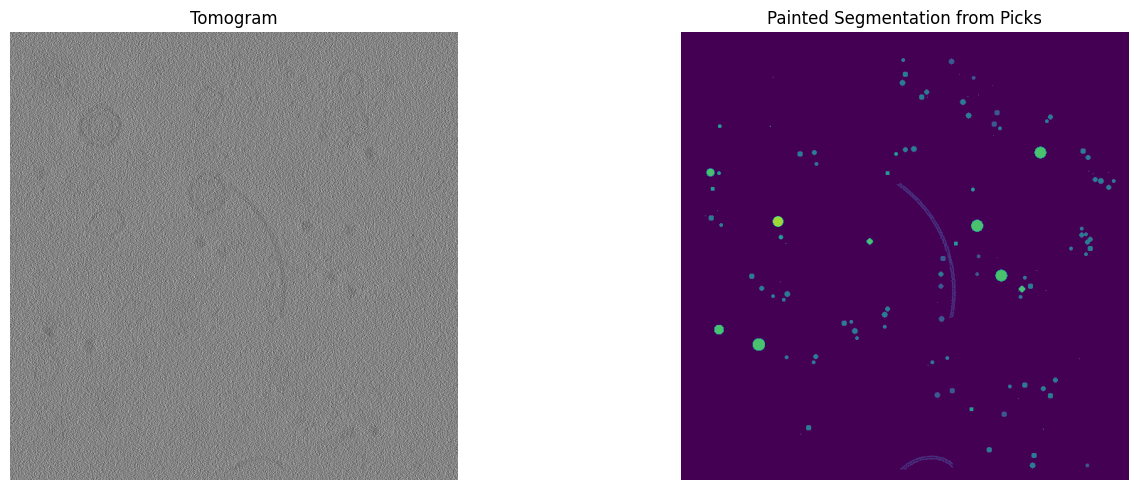

In [10]:
import matplotlib.pyplot as plt

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(data_dicts[0]['image'][90],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Painted Segmentation from Picks')
plt.imshow(data_dicts[0]['label'][90], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()

### 5. Prepare dataloaders

In [11]:
my_num_samples = 16
train_batch_size = 1
val_batch_size = 1

test_files = data_dicts[-2:]
train_files, val_files = train_test_split(data_dicts[:-2], test_size=0.3)
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),    
])

# Create the cached dataset with non-random transforms
train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
train_ds = Dataset(data=train_ds, transform=random_transforms)

# DataLoader remains the same
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Validation transforms
val_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples,  # Use 1 to get a single, consistent crop per image
    ),
])

# Create validation dataset
val_ds = CacheDataset(data=val_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
val_ds = Dataset(data=val_ds, transform=random_transforms)

# Create validation DataLoader
val_loader = DataLoader(
    val_ds,
    batch_size=val_batch_size,
    num_workers=4,
    pin_memory=torch.cuda.is_available(),
    shuffle=False,  # Ensure the data order remains consistent
)

## Model setup

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Create UNet, DiceLoss and Adam optimizer
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(root.pickable_objects)+1,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
).to(device)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
#loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
loss_function = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass
recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")

cuda


In [14]:
post_pred = AsDiscrete(argmax=True, to_onehot=len(root.pickable_objects)+1)
post_label = AsDiscrete(to_onehot=len(root.pickable_objects)+1)

def train(train_loader, model, loss_function, metrics_function, optimizer, max_epochs=100):
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"batch {step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)
                    val_outputs = model(val_inputs)
                    metric_val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    metric_val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    
                    
                    # compute metric for current iteration
                    metrics_function(y_pred=metric_val_outputs, y=metric_val_labels)

                metrics = metrics_function.aggregate(reduction="mean_batch")
                metric_per_class = ["{:.4g}".format(x) for x in metrics]
                metric = torch.mean(metrics).numpy(force=True)
                mlflow.log_metric("validation metric", metric, step=epoch+1)
                for i,m in enumerate(metrics):
                    mlflow.log_metric(f"validation metric class {i+1}", m, step=epoch+1)
                metrics_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join('./', "best_metric_model.pth"))
                    
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean recall per class: {', '.join(metric_per_class)}"
                    f"\nbest mean recall: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

## Training and tracking

In [15]:
from torchinfo import summary

mlflow.end_run()
mlflow.set_experiment('training 3D U-Net model for the cryoET ML Challenge')
epochs = 200
with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "loss_function": loss_function.__class__.__name__,
        "metric_function": recall_metric.__class__.__name__,
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    train(train_loader, model, loss_function, dice_metric, optimizer, max_epochs=epochs)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")



----------
epoch 1/200
batch 1/1, train_loss: 0.9684
batch 2/1, train_loss: 0.9622
epoch 1 average loss: 0.9653
----------
epoch 2/200
batch 1/1, train_loss: 0.9553
batch 2/1, train_loss: 0.9497
epoch 2 average loss: 0.9525
saved new best metric model
current epoch: 2 current mean recall per class: 0.01441, 0.001934, 0.00928, 0.000753, 0.01625, 0.003847, 0.001422
best mean recall: 0.0068 at epoch: 2
----------
epoch 3/200
batch 1/1, train_loss: 0.9448
batch 2/1, train_loss: 0.9399
epoch 3 average loss: 0.9424
----------
epoch 4/200
batch 1/1, train_loss: 0.9364
batch 2/1, train_loss: 0.9321
epoch 4 average loss: 0.9343
saved new best metric model
current epoch: 4 current mean recall per class: 0.01214, 0.001868, 0.008276, 0.0006326, 0.03072, 0.003754, 0.001329
best mean recall: 0.0084 at epoch: 4
----------
epoch 5/200
batch 1/1, train_loss: 0.9292
batch 2/1, train_loss: 0.9260
epoch 5 average loss: 0.9276
----------
epoch 6/200
batch 1/1, train_loss: 0.9227
batch 2/1, train_loss: 0.91

2024/09/24 23:34:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


current epoch: 200 current mean recall per class: 0.1071, 0.1187, 0.08119, 0.05869, 0.4401, 0.331, 0.2556
best mean recall: 0.2142 at epoch: 198


2024/09/24 23:34:35 WARNING mlflow.utils.requirements_utils: Found torchaudio version (2.4.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchaudio==2.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/09/24 23:34:35 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.19.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.19.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
/hpc/mydata/kevin.zhao/miniconda3/envs/mlchallenge/lib/python3.9/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated